In [114]:
import os 
import os.path as osp
import numpy as np 
import cv2
import open3d as o3d
import json
import pickle
import matplotlib.pyplot as plt
import glob

#the other imports from the local stuff
import sys

ws_dir = '/local/home/ekoller/BT'
print(ws_dir)
sys.path.append(ws_dir)
from utils import scan3r,visualisation

/local/home/ekoller/BT


In [2]:
#reading in the necessary data
data_dir ='/local/home/ekoller/R3Scan'
scenes_dir = '/local/home/ekoller/R3Scan/scenes'
scan_id= "38770c95-86d7-27b8-8717-3485b411ddc7" #is reference scan  since it is a reference scan everything shouls be correctly hit
frame_number = "000015"
img_width = 960
img_height = 540

curr_scan_id = "38770c9d-86d7-27b8-869e-4f713b04f290" #is ref 1d2f8510-d757-207c-8c48-3684433860e1
new_scan_id =  "38770c95-86d7-27b8-8717-3485b411ddc7" #is rescan 9c27de56-6184-2cda-8196-591957b6387d

#the original meshes are given in the file  'labels.instances.annotated.v2.ply


This code segment does the following: given a mesh of the scene, create the camera rays and intersect them with the mesh- For every camera pose do the following: the camera pose is given in the original frame of the scan: if reference scan in reference coordinates, if rescan in rescan coordinates. To do the computations the designdecision is the following:  use the aligned version of the rescan so that the mesh is in the reference coordinate system. in this coordinate system you can then compare the two things. Compare the object of the intersection of the current mesh with the one of the new mesh


Logic for the try out data: in the gt_tmp we have for every scene a folder with the frame of the ground truth projection
in the projection file we have the following way of storing things projection/curr_scene_id/(color/global_id/obj_id)/projection_pose_in_new_scene_id_000033

In [3]:
#the function which actually does the intersection part
def segmentResult(scene, intrinsics, extrinsics, width, height,
                      mesh_triangles, num_triangles, colors, obj_ids, global_ids):
        
        #create the rays to shoot in the scene
        rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
            intrinsic_matrix = intrinsics.astype(np.float64),
            extrinsic_matrix = extrinsics.astype(np.float64),
            width_px = width, height_px = height
        )
        
       
        #find the intersections of the rays
        ans = scene.cast_rays(rays)
        hit_triangles_ids = ans['primitive_ids'].numpy()
        hit_triangles_ids_valid_masks = (hit_triangles_ids<num_triangles)
        hit_triangles_ids_valid = hit_triangles_ids[hit_triangles_ids_valid_masks]
        hit_triangles_valid = mesh_triangles[hit_triangles_ids_valid]
        hit_points_ids_valid = hit_triangles_valid[:,0]
        
        #create resulting maps initialized to 0
        color_map = np.zeros((height,width,3), dtype=np.uint8)
        obj_id_map = np.zeros((height,width), dtype=np.uint8)
        global_id_map = np.zeros((height,width), dtype=np.uint8)

        #go through the array and add the corresponding values
        color_map[hit_triangles_ids_valid_masks] = colors[hit_points_ids_valid]
        obj_id_map[hit_triangles_ids_valid_masks] = obj_ids[hit_points_ids_valid]
        global_id_map[hit_triangles_ids_valid_masks] = global_ids[hit_points_ids_valid]
        
        return color_map, obj_id_map, global_id_map

In [4]:
#given a scan id and a corresponding frame number in the same coordinate system sanity check if the same as groundtruth
def project_mesh_gt_generation(data_dir,scenes_dir, scan_id, frame_number):
        # get related files
        mesh_file = osp.join(scenes_dir, scan_id, "labels.instances.align.annotated.v2.ply") #exists for bot reference and rescan
        

        # get img info and camera intrinsics 
        camera_info = scan3r.load_intrinsics(scenes_dir, scan_id)
        intrinsics = camera_info['intrinsic_mat']
        img_width = int(camera_info['width'])
        img_height = int(camera_info['height'])
        
        # load labels
        plydata_npy = np.load(osp.join(scenes_dir, scan_id, "data.npy"), allow_pickle=True)
        
        #print the names of the datafields
        # if plydata_npy.dtype.names:
        #         for name in plydata_npy.dtype.names:
        #              print(f"Field: {name}")
        #              print(plydata_npy[name])
        # else:
        #     print(plydata_npy)


        #get the corresponding ids
        obj_labels = plydata_npy['objectId']
        global_labels = plydata_npy['globalId']
    
      
    
        # load mesh and scene
        mesh = o3d.io.read_triangle_mesh(mesh_file)
        mesh_triangles = np.asarray(mesh.triangles)
        #also load the colour
        colors = np.asarray(mesh.vertex_colors)*255.0
        colors = colors.round()
        num_triangles = mesh_triangles.shape[0]
        scene = o3d.t.geometry.RaycastingScene()
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))
        
        # get frame_indexes
        frame_idxs = frame_number
        poses = scan3r.load_pose(scenes_dir, scan_id, frame_number)
        
        # project 3D model using rays
        obj_id_imgs = {}
        global_id_imgs = {}
        color_imgs = {}
        for idx in range(0, len(poses), 1):
            #frame_idx = frame_idxs[idx] #adjusted for single use in this jupiter notebook
            frame_idx = frame_idxs
            #img_pose = poses[idx] #adjusted for single use in this jupiter notebook
            img_pose = poses # camera to rescan 0
        
            extrinsic = np.linalg.inv(img_pose) #rescan to camera  1
         
            
            if scan3r.is_rescan(data_dir, scan_id):
                 #need to adjust the extrinsic matrix to the reference coordinate system
                #get the path to the matricies of each scan_id for transformation of rescan to reference
                path = osp.join(data_dir,"files", "3RScan.json")
                ref2_rescan_all_id = scan3r.read_transform_mat(path)
                ref2rescan = ref2_rescan_all_id[scan_id] #2
                rescan2ref = np.linalg.inv(ref2rescan) #3
                
 
                #multiply such that we get transformation of camera to reference scan
                cam2ref =     extrinsic * rescan2ref.transpose()
            
                #extrinsic = np.linalg.inv(cam2ref)
                #convert
                extrinsic = np.asarray(cam2ref)
               

              
            
            #get the mappings for the image
            color_map, obj_id_map, global_id_map = segmentResult(
                scene, intrinsics, extrinsic, img_width, img_height, 
                mesh_triangles, num_triangles, colors, obj_labels, global_labels
            )
            obj_id_imgs[frame_idx] = obj_id_map
            global_id_imgs[frame_idx] = global_id_map
            color_imgs[frame_idx] = color_map
            
        #create directories (here tmp to try out & save 
        save_scan_color_dir = osp.join(data_dir, "gt_tmp", scan_id, "color")
        save_scan_obj_dir = osp.join(data_dir, "gt_tmp", scan_id, "obj_id")
        save_scan_global_dir = osp.join(data_dir, "gt_tmp", scan_id, "global_id")

        #make sure the directories exist
        for dir_path in [save_scan_color_dir, save_scan_obj_dir, save_scan_global_dir]:
            try:
                os.makedirs(dir_path, exist_ok=True)
            except Exception as e:
                print(f"Failed to create directory {dir_path}: {e}")

        
        for frame_idx in obj_id_imgs:
            obj_id_img = obj_id_imgs[frame_idx]
            global_id_img = global_id_imgs[frame_idx]
            color_img = color_imgs[frame_idx]
            
            
            img_name = "gt_frame-"+str(frame_idx)+".jpg"
            obj_id_img_file = osp.join(save_scan_obj_dir, img_name)
            global_img_file = osp.join(save_scan_global_dir, img_name)
            color_img_file = osp.join(save_scan_color_dir, img_name)
            success_obj = cv2.imwrite(obj_id_img_file, obj_id_img)
            success_global = cv2.imwrite(global_img_file, global_id_img)
            success_color = cv2.imwrite(color_img_file, color_img)

            #also vusually double check if the images are correct
            # cv2.imshow("object_id", obj_id_img)
            # cv2.imshow("global_id", global_id_img)
            # cv2.imshow("color", color_img)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()





In [5]:
#try out the ground truth generation
project_mesh_gt_generation(data_dir,scenes_dir, scan_id, frame_number)


In [115]:
#given a current scene and a new scene: the reference scene is in the reference coordinate system, in this we will project the current camera frame & perform
#raytracing based on the new camera pose onto the current mesh
#frame number is for the new_scan_id
#returns numpy arrays of object_id, color, global_id
def project_mesh_diff(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number):

    """
    Read/prepare the data of the current mesh (mesh, colours, objid, globalid)
    """
    #get the current coordinate system the reference coordinate system
    mesh_file = osp.join(scenes_dir, curr_scan_id, "labels.instances.align.annotated.v2.ply") #exists for bot reference and rescan
        


    # load labels based on current mesh "status quo"
    plydata_npy = np.load(osp.join(scenes_dir, curr_scan_id, "data.npy"), allow_pickle=True)
      
    obj_labels = plydata_npy['objectId']
    global_labels = plydata_npy['globalId']
    

    # load curr mesh and scene
    mesh = o3d.io.read_triangle_mesh(mesh_file)
    mesh_triangles = np.asarray(mesh.triangles)
    #also load the colour
    colors = np.asarray(mesh.vertex_colors)*255.0
    colors = colors.round()
    num_triangles = mesh_triangles.shape[0]
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))


    """
    Read/prepare the data of the new mesh (pose, intrinsics)
    """
    # get img info and camera intrinsics of the new img
    camera_info = scan3r.load_intrinsics(scenes_dir, new_scan_id)
    intrinsics = camera_info['intrinsic_mat']
    img_width = int(camera_info['width'])
    img_height = int(camera_info['height'])

    # get frame_indexes and pose of the new
    frame_idxs = frame_number
    poses = scan3r.load_pose(scenes_dir, new_scan_id, frame_number)


    """
    Do the intersection
    """

    # project 3D model using rays
    obj_id_imgs = {}
    global_id_imgs = {}
    color_imgs = {}
    for idx in range(0, len(poses), 1):
        #frame_idx = frame_idxs[idx] #adjusted for single use in this jupiter notebook
        frame_idx = frame_idxs
        #img_pose = poses[idx] #adjusted for single use in this jupiter notebook
        img_pose = poses
        extrinsic = np.linalg.inv(img_pose)

        if scan3r.is_rescan(data_dir, new_scan_id):
            #need to adjust the extrinsic matrix to the reference coordinate system
            #get the path to the matricies of each scan_id for transformation of rescan to reference
            path = osp.join(data_dir,"files", "3RScan.json")
            ref2_rescan_all_id = scan3r.read_transform_mat(path)
            ref2rescan = ref2_rescan_all_id[new_scan_id] #2
            rescan2ref = np.linalg.inv(ref2rescan) #3
            

            #multiply such that we get transformation of camera to reference scan
            cam2ref =     extrinsic * rescan2ref.transpose()
    
            #convert
            extrinsic = np.asarray(cam2ref)




        #get the mappings for the image
        color_map, obj_id_map, global_id_map = segmentResult(
            scene, intrinsics, extrinsic, img_width, img_height, 
            mesh_triangles, num_triangles, colors, obj_labels, global_labels
        )
        obj_id_imgs[frame_idx] = obj_id_map
        global_id_imgs[frame_idx] = global_id_map
        color_imgs[frame_idx] = color_map

   
        
    #create directories (here tmp to try out & save 
    save_scan_color_dir = osp.join(data_dir, "proj", curr_scan_id, "color")
    save_scan_obj_dir = osp.join(data_dir, "proj", curr_scan_id, "obj_id")
    save_scan_global_dir = osp.join(data_dir, "proj", curr_scan_id, "global_id")

    #make sure the directories exist
    for dir_path in [save_scan_color_dir, save_scan_obj_dir, save_scan_global_dir]:
        try:
            os.makedirs(dir_path, exist_ok=True)
            
        except Exception as e:
            print(f"Failed to create directory {dir_path}: {e}")

    
    for frame_idx in obj_id_imgs:
        obj_id_img = obj_id_imgs[frame_idx]
        global_id_img = global_id_imgs[frame_idx]
        color_img = color_imgs[frame_idx]

        
        img_name = "proj_pose_"+ str(new_scan_id)+"_"+str(frame_idx)+".jpg"
        obj_id_img_file = osp.join(save_scan_obj_dir, img_name)
        global_img_file = osp.join(save_scan_global_dir, img_name)
        color_img_file = osp.join(save_scan_color_dir, img_name)
        success_obj = cv2.imwrite(obj_id_img_file, obj_id_img)
        success_global = cv2.imwrite(global_img_file, global_id_img)
        success_color = cv2.imwrite(color_img_file, color_img)

        #also vusually double check if the images are correct
        # cv2.imshow("object_id", obj_id_img)
        # cv2.imshow("global_id", global_id_img)
        # cv2.imshow("color", color_img)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()   

    
    

In [117]:
project_mesh_diff(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number)

This code segment does the bounding box generation for the semantic meshes of the reference scan, the boundingboxes of the rescan are handeled by sam. to compute the boundin boxes we need the pose/extrinsics/intrinsics of the new_scan_id

In [147]:
#do the boundinboxes based on the projection! for reference scan
def compute_2d_boundingboxes_3rscam(data_dir, curr_scan_id, new_scan_id):
    #go to the folder of the scene
    folder_path = osp.join(data_dir, "scenes", new_scan_id, "sequence")
    print("folderpath", folder_path)
    file_pattern = 'frame-*.color.jpg'


    #search for all the colour files
    file_list = glob.glob(os.path.join(folder_path, file_pattern))
    print("file list", file_list)

    #create a directory in which the boxes get saved
    output_path = osp.join(data_dir, "proj", curr_scan_id, "bboxes")
    try:
        os.makedirs(output_path, exist_ok=True)
    except Exception as e:
        print(f"Failed to create directory {output_path}: {e}")

   
    for file in file_list:
       
        #basically extract the frame number
        base_name = os.path.basename(file)
        name_parts = base_name.split('.')
        frame_number = name_parts[0].split('-')[1]
        #project the current position of the file onto it
        project_mesh_diff(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number) 
        #access the result of the projection
        path2proj = osp.join(data_dir,"proj", curr_scan_id, "obj_id/proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
        img = cv2.imread(path2proj,cv2.IMREAD_UNCHANGED)
        #print("img", img)

        unique_ids = np.unique(img)
        bounding_boxes = []

        # Iterate over each unique object ID
        for obj_id in unique_ids:

            # Get the indices of all occurrences of the current object ID
            indices = np.where(img == obj_id)
            
            # Calculate min and max indices for both axes
            min_y = np.min(indices[0])
            max_y = np.max(indices[0])
            min_x = np.min(indices[1])
            max_x = np.max(indices[1])
            height = max_y - min_y + 1
            width = max_x - min_x + 1

            # Append the results to the bounding_boxes array
            bounding_boxes.append([obj_id, min_x, min_y, width, height])
        #order them in ascending order
        bounding_boxes = np.array(bounding_boxes)
        bounding_boxes = bounding_boxes[np.argsort(bounding_boxes[:, 0])]

        #save the boundingboxes into the correct file
        path2bboxes = osp.join(data_dir,"proj", curr_scan_id, "bboxes","proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".npy")
        np.save(path2bboxes, bounding_boxes)
        


    
    
       




In [148]:
compute_2d_boundingboxes_3rscam(data_dir, curr_scan_id, new_scan_id)

folderpath /local/home/ekoller/R3Scan/scenes/38770c95-86d7-27b8-8717-3485b411ddc7/sequence
file list ['/local/home/ekoller/R3Scan/scenes/38770c95-86d7-27b8-8717-3485b411ddc7/sequence/frame-000478.color.jpg', '/local/home/ekoller/R3Scan/scenes/38770c95-86d7-27b8-8717-3485b411ddc7/sequence/frame-001172.color.jpg', '/local/home/ekoller/R3Scan/scenes/38770c95-86d7-27b8-8717-3485b411ddc7/sequence/frame-001063.color.jpg', '/local/home/ekoller/R3Scan/scenes/38770c95-86d7-27b8-8717-3485b411ddc7/sequence/frame-000246.color.jpg', '/local/home/ekoller/R3Scan/scenes/38770c95-86d7-27b8-8717-3485b411ddc7/sequence/frame-001239.color.jpg', '/local/home/ekoller/R3Scan/scenes/38770c95-86d7-27b8-8717-3485b411ddc7/sequence/frame-001233.color.jpg', '/local/home/ekoller/R3Scan/scenes/38770c95-86d7-27b8-8717-3485b411ddc7/sequence/frame-000296.color.jpg', '/local/home/ekoller/R3Scan/scenes/38770c95-86d7-27b8-8717-3485b411ddc7/sequence/frame-000800.color.jpg', '/local/home/ekoller/R3Scan/scenes/38770c95-86d7-2

KeyboardInterrupt: 

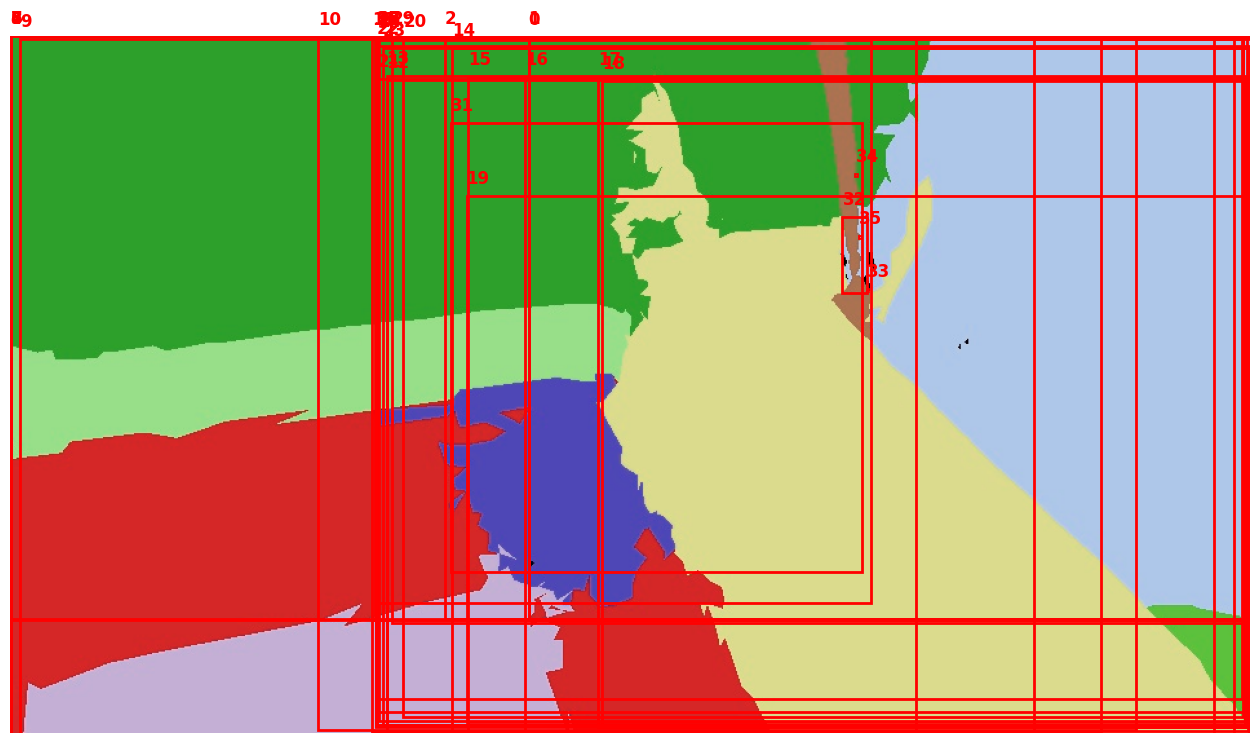

In [155]:
def visualize_bboxes(data_dir, curr_scan_id, new_scan_id, frame_number):
    #get the image first
    bounding_boxes = np.load(osp.join(data_dir,"proj", curr_scan_id, "bboxes","proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".npy"))
    image_rgb = cv2.imread(osp.join(data_dir,"proj", curr_scan_id, "color","proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg"),cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.figure(figsize=(16, 16))
    plt.imshow(image_rgb)

    #plot the boundingboxes
    for bbox in bounding_boxes:
        obj_id, x_min, y_min,  width, height = bbox
        
        # Create a rectangle patch
        rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        # Add the rectangle to the plot
        plt.gca().add_patch(rect)
        
        # Add object id text
        plt.text(x_min, y_min - 10, str(obj_id), color='red', fontsize=12, weight='bold')

    # Show the plot with bounding boxes
    plt.axis('off')  # Hide axes
    plt.show()

visualize_bboxes(data_dir,curr_scan_id,new_scan_id, frame_number)



In [111]:
#this thind does not work!!!
def vis_projection_of_2d_bounding_box(data_dir, curr_scan_id, new_scan_id, frame_number):


    #get the info of which object ids are in the image
    project_mesh_diff(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number)
    obj_path = osp.join(data_dir,"proj", curr_scan_id, "obj_id","projection_pose_in_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
    print("path", obj_path)

    curr_obj = cv2.imread(obj_path, cv2.IMREAD_UNCHANGED)
    unique_ids, counts = np.unique(curr_obj, return_counts=True)
    id_count_dict = dict(zip(unique_ids, counts))
    ids_more_than_1000 = [id for id, count in sorted(id_count_dict.items(), key=lambda item: item[1], reverse=True) if count > 1000]
    print("ids more than 1000", ids_more_than_1000)
    #print("curr obj ", curr_obj)

    current_id_E = ids_more_than_1000[0]
    print("current_id_E", current_id_E)

    # #load the boundingboxes from the original file
    # bounding_boxes = [ ]

    # json_bounding_box = osp.join(data_dir, 'scenes', curr_scan_id, 'semseg.v2.json')

    # with open(json_bounding_box, 'r') as file:
    #     data = json.load(file)


    # for object in data['segGroups']:
    #     if object["objectId"] != current_id_E:
    #         continue
    #     # the axes lengths give the length in each direction of one axis -> from centroid we have to move in 
    #     # both  directions of x in + and -
    #     axes_lengths = object['obb']['axesLengths']

    #     # the normaliyed axis are the directions in which the boundingbox points to in comparison to the coord system
    #     #we can use them to create a transformationmatrix! every row is one of the vector
    #     normalized_axes = object['obb']["normalizedAxes"]

    #     #construct the matrix using collumnformat ( each vecor becomes a collumn based on 2d example)
    #     matrix = np.reshape(normalized_axes, (3,3), order= "F")

    #     #compute the new axislengths
    #     lengths = matrix.dot(axes_lengths)
        
    #     #the centriod of the object
    #     centroid = object['obb']["centroid"]

    #     # calculate the new points one time in + direction one time in -
    #     # get half of the lengths to add in each direction
    #     points = np.zeros
    #     half_lengths = lengths / 2.0

    #     #not pretty bus shows clearly where it is going looks like the following BT/Illustrations
    #     corners = np.array([
    #     centroid + np.array([+1, +1, -1]) * half_lengths, #1
    #     centroid + np.array([-1, +1, -1]) * half_lengths, #5
    #     centroid + np.array([-1, -1, -1]) * half_lengths, #7
    #     centroid + np.array([+1, -1, -1]) * half_lengths, #3
    #     centroid + np.array([+1, +1, +1]) * half_lengths, #0
    #     centroid + np.array([-1, +1, +1]) * half_lengths, #4
    #     centroid + np.array([-1, -1, +1]) * half_lengths, #6
    #     centroid + np.array([+1, -1, +1]) * half_lengths, #2  
    #     ])
    #     #add the cornerarray of the object to the bounding box
    #     bounding_boxes.append(corners)

    # bounding_boxes = np.array(bounding_boxes)
    # #print("bounding boxes", bounding_boxes)


    """
    Get the boundingboxes
    """
    pklfile = osp.join('/local/home/ekoller/R3Scan', 'files', 'orig', 'data', '{}.pkl'.format(curr_scan_id) )
    with open(pklfile, "rb") as f:
            # Load the data
            data = pickle.load(f)
            bounding_boxes = data['bounding_boxes'] 
            obj_ids= data["objects_id"]

 

    """
    Get the transformations of the camera from rescan and transform into this coordinate system
    """

    poses = scan3r.load_pose(scenes_dir, new_scan_id, frame_number)

    for idx in range(0, len(poses), 1):
        #frame_idx = frame_idxs[idx] #adjusted for single use in this jupiter notebook
        frame_idx = frame_number
        #img_pose = poses[idx] #adjusted for single use in this jupiter notebook
        img_pose = poses
        extrinsic = np.linalg.inv(img_pose) #rescan to camera

        if scan3r.is_rescan(data_dir, new_scan_id):
            #need to adjust the extrinsic matrix to the reference coordinate system
            #get the path to the matricies of each scan_id for transformation of rescan to reference
            path = osp.join(data_dir,"files", "3RScan.json")
            ref2_rescan_all_id = scan3r.read_transform_mat(path)
            ref2rescan = ref2_rescan_all_id[new_scan_id] #2
            rescan2ref = np.linalg.inv(ref2rescan) #3
        

            #multiply such that we get transformation of camera to reference scan
            cam2ref =     extrinsic * rescan2ref.transpose()

            #convert
            extrinsic = np.asarray(cam2ref)

    """
    transform the bounding boxes into the camera space using the extrinsic matrix
    """
    camera_info = scan3r.load_intrinsics(scenes_dir, scan_id)
    intrinsic = camera_info['intrinsic_mat'] #camera to image plane
    boundingboxes_2d = []

    #do it for only one box


    #actually get only one boundingbox and try out until we get that one correct!
    i_idx = np.where(obj_ids == current_id_E)[0][0]
    print("i_idx", i_idx)
    #compute the transrofmation
    bounding_box = bounding_boxes[i_idx]
    print("bounding box", bounding_box)
    vertices_homogeneous = np.hstack([bounding_box, np.ones((bounding_box.shape[0], 1))])
    print("vertices_HOMOG", vertices_homogeneous)

    vertices_rescan = np.dot(vertices_homogeneous, ref2rescan)
    print("vertices in rescan", vertices_rescan)

    # Apply extrinsic matrix
    vertices_camera_space =  extrinsic @vertices_homogeneous.T
    print("vectors camera space", vertices_camera_space)
    #normalize the vector
    vertices_camera_space = vertices_camera_space[:, :3] / vertices_camera_space[:, 3, None]
    print("normalized vectors camera space", vertices_camera_space)

    print("verticies camera space", vertices_camera_space)
    # Check if any z-coordinate is negative (behind the camera)
    if np.any(vertices_camera_space[2, :] <= 0):
        print("behind the cameraa")

   
    # Apply intrinsic matrix
    print("intrinsic shapt", intrinsic.shape)
    print("verticies camera space shape", vertices_camera_space[:3,:].shape)
    vertices_image_space = intrinsic @ vertices_camera_space[:3, :]

    print("vertivies image spacce", vertices_image_space)
    # Normalize by the third (z) coordinate
    vertices_image_space = vertices_image_space[:, :2] / vertices_image_space[:, 2, None]
    print("normalized vertivies image spacce", vertices_image_space)

    projected = vertices_image_space[:2, :].T

    x_min = np.min(projected[:, 0])
    y_min = np.min(projected[:, 1])
    x_max = np.max(projected[:, 0])
    y_max = np.max(projected[:, 1])

    boundingboxes_2d.append(np.array([x_min,x_max,y_min,y_max]))
    boundingboxes_2d =np.array(boundingboxes_2d)
    boundingboxes_2d_int = (boundingboxes_2d).astype(int)


    print("boundingboxes_2d", boundingboxes_2d)



    # #compute the transrofmation
    # for bounding_box in bounding_boxes:
    #     #print("bounding box", bounding_box)
    #     vertices_homogeneous = np.hstack([bounding_box, np.ones((bounding_box.shape[0], 1))])
    #     # Apply extrinsic matrix
    #     vertices_camera_space = extrinsic @ vertices_homogeneous.T
    #     # Check if any z-coordinate is negative (behind the camera)
    #     if np.any(vertices_camera_space[2, :] <= 0):
    #         continue
    #     # Apply intrinsic matrix
    #     print("intrinsic shapt", intrinsic.shape)
    #     print("verticies camera space shape", vertices_camera_space[:3,:].shape)
    #     vertices_image_space = intrinsic @ vertices_camera_space[:3, :]
    #     # Normalize by the third (z) coordinate
    #     vertices_image_space /= vertices_image_space[2, :]

    #     projected = vertices_image_space[:2, :].T

    #     x_min = np.min(projected[:, 0])
    #     y_min = np.min(projected[:, 1])
    #     x_max = np.max(projected[:, 0])
    #     y_max = np.max(projected[:, 1])

    #     boundingboxes_2d.append(np.array([x_min,x_max,y_min,y_max]))

    # print("boundingboxes_2d", boundingboxes_2d)

    """
    also display the boundingboxes and plot the image
    """

    
    project_mesh_diff(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number)
    img_path = osp.join(data_dir,"proj", curr_scan_id, "color","projection_pose_in_"+ str(new_scan_id)+"_"+str(frame_idx)+".jpg")

    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)




    for bbox in boundingboxes_2d_int:
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    plt.imshow(image)
    plt.show()






path /local/home/ekoller/R3Scan/proj/38770c9d-86d7-27b8-869e-4f713b04f290/obj_id/projection_pose_in_38770c95-86d7-27b8-8717-3485b411ddc7_000015.jpg
ids more than 1000 [6, 15, 1, 8, 9, 5, 26, 25, 27, 7, 14, 16, 0]
current_id_E 6
i_idx 5
bounding box [[-2.09306843  1.11629232 -1.36999996]
 [-3.22220335  1.11629232 -1.36999996]
 [-3.22220335 -0.53642625 -1.36999996]
 [-2.09306843 -0.53642625 -1.36999996]
 [-2.09306843  1.11629232  1.04999994]
 [-3.22220335  1.11629232  1.04999994]
 [-3.22220335 -0.53642625  1.04999994]
 [-2.09306843 -0.53642625  1.04999994]]
vertices_HOMOG [[-2.09306843  1.11629232 -1.36999996  1.        ]
 [-3.22220335  1.11629232 -1.36999996  1.        ]
 [-3.22220335 -0.53642625 -1.36999996  1.        ]
 [-2.09306843 -0.53642625 -1.36999996  1.        ]
 [-2.09306843  1.11629232  1.04999994  1.        ]
 [-3.22220335  1.11629232  1.04999994  1.        ]
 [-3.22220335 -0.53642625  1.04999994  1.        ]
 [-2.09306843 -0.53642625  1.04999994  1.        ]]
vertices in re

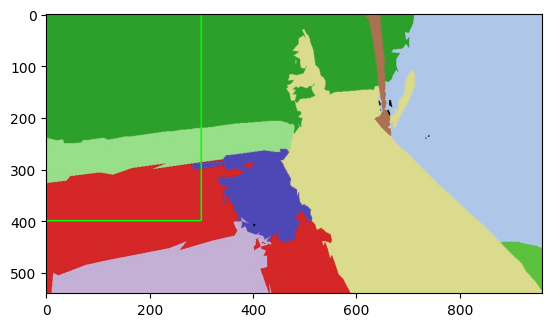

In [112]:
vis_2d_bounding_box(data_dir, curr_scan_id, new_scan_id, frame_number)

In [7]:
#this code returns the colour segmentation of the gt projection on pixelwise level
def load_gt_color_annos(data_dir, scan_id, skip=None):
    anno_imgs = {}
    frame_idxs = scan3r.load_frame_idxs(osp.join(data_dir, "scenes"), scan_id, skip)
    anno_folder = osp.join(data_dir, "files", 'gt_projection/color', scan_id)
    for frame_idx in frame_idxs:
        anno_color_file = osp.join(anno_folder, "frame-{}.jpg".format(frame_idx))
        anno_color = cv2.imread(anno_color_file, cv2.IMREAD_UNCHANGED)
        anno_imgs[frame_idx] = anno_color
    return anno_imgs

In [8]:
#this code returns the object_id segmentation of the gt projection on pixelwise level
def load_gt_obj_id_annos(data_dir, scan_id, skip=None):
    anno_imgs = {}
    frame_idxs = scan3r.load_frame_idxs(osp.join(data_dir, "scenes"), scan_id, skip)
    anno_folder = osp.join(data_dir, "files", 'gt_projection/obj_id', scan_id)
    for frame_idx in frame_idxs:
        anno_obj_file = osp.join(anno_folder, "frame-{}.jpg".format(frame_idx))
        anno_obj = cv2.imread(anno_obj_file, cv2.IMREAD_UNCHANGED)
        anno_imgs[frame_idx] = anno_obj
    return anno_imgs

In [9]:
#this code returns the colour segmentation of the gt projection on pixelwise level
def load_gt_gloabl_id_annos(data_dir, scan_id, skip=None):
    anno_imgs = {}
    frame_idxs = scan3r.load_frame_idxs(osp.join(data_dir, "scenes"), scan_id, skip)
    anno_folder = osp.join(data_dir, "files", 'gt_projection/global_id', scan_id)
    for frame_idx in frame_idxs:
        anno_global_file = osp.join(anno_folder, "frame-{}.jpg".format(frame_idx))
        anno_global = cv2.imread(anno_global_file, cv2.IMREAD_UNCHANGED)
        anno_imgs[frame_idx] = anno_global
    return anno_imgs

In [10]:
#this function gives the transformation on a pixelwise level between the current mesh and the new mesh
#this method goes over the projection and the semantically segmented image provided as input from (new_scan_id)
#it stores the mask following the logic described above
def get_transformation_mask(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number):

    #the ground truth of the new scan id must exist already
    #project_mesh_gt_generation(data_dir,scenes_dir, new_scan_id, frame_number)
    


    #get the information of the rgb image of new_scan_id based on the ground truth (this code is for after the ground truth has beeen generated)
    gt_colors = load_gt_color_annos(data_dir,new_scan_id)
    gt_obj_ids = load_gt_obj_id_annos(data_dir, new_scan_id)
    gt_global_ids = load_gt_gloabl_id_annos(data_dir,new_scan_id)

    #get the infor for the specific frame number
    gt_color = gt_colors[frame_number]
    gt_obj_id = gt_obj_ids[frame_number]
    gt_global_id= gt_global_ids[frame_number]

    # scan_color_file = osp.join(data_dir, "gt_tmp", new_scan_id, "color","gt_frame-{}.jpg".format(frame_number))
    # scan_obj_file = osp.join(data_dir, "gt_tmp", new_scan_id, "obj_id","gt_frame-{}.jpg".format(frame_number))
    # scan_global_file = osp.join(data_dir, "gt_tmp", new_scan_id, "global_id","gt_frame-{}.jpg".format(frame_number))

    # gt_color = cv2.imread(scan_color_file, cv2.IMREAD_UNCHANGED)
    # gt_obj_id = cv2.imread(scan_obj_file, cv2.IMREAD_UNCHANGED)
    # gt_global_id= cv2.imread(scan_global_file, cv2.IMREAD_UNCHANGED)


    """
    until here the dimensions and entries are as excpected, however not something is wrong with the way the matrix is saved and filled
    """
    #get the rayintersection of the mesh based on the new computations
    #compute the intersections and maps
    project_mesh_diff(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number)
    color_path = osp.join(data_dir,"proj",curr_scan_id, "color","projection_pose_in_{}_{}.jpg".format(new_scan_id,frame_number))
    obj_path = osp.join(data_dir,"proj",curr_scan_id, "obj_id","projection_pose_in_{}_{}.jpg".format(new_scan_id,frame_number))
    gloabl_path = osp.join(data_dir,"proj",curr_scan_id, "global_id","projection_pose_in_{}_{}.jpg".format(new_scan_id,frame_number))

    #access the files
    pj_color = cv2.imread(color_path, cv2.IMREAD_UNCHANGED)
    pj_obj_id = cv2.imread(obj_path, cv2.IMREAD_UNCHANGED)
    pj_global_id = cv2.imread(gloabl_path, cv2.IMREAD_UNCHANGED)

   

    img_height, img_width, channels = pj_color.shape
    #iterate through the whole image 
    curr_res_color = np.full_like(gt_color, 0)
    curr_res_obj_id = np.full((img_height,img_width,1), 0)
    curr_res_global_id = np.full((img_height,img_width,1), 0)
   

    new_res_color = np.full_like(gt_color, 0)
    new_res_obj_id = np.full((img_height,img_width,1), 0)
    new_res_global_id = np.full((img_height,img_width,1), 0)

    #make the mask: originally black: wherever there is a difference take the value of the new_scan_id gt

    

   
    for i in range(img_height):
        for j in range(img_width):
            if (pj_obj_id[i][j] != gt_obj_id[i][j]):
                #the new values in the modified area
                new_res_color[i][j] = gt_color[i][j]
                new_res_obj_id[i][j] = gt_obj_id[i][j]
                new_res_global_id[i][j] = gt_global_id[i][j]

                #the values which are impacted in curr 
                curr_res_color[i][j] = pj_color[i][j]
                curr_res_obj_id[i][j] = pj_obj_id[i][j]
                curr_res_global_id[i][j] = pj_global_id[i][j]


    #also save the files as needed
    #create directories (here tmp to try out & save 
    save_mask_color_dir = osp.join(data_dir, "mask", curr_scan_id, "color")
    save_mask_obj_dir = osp.join(data_dir, "mask", curr_scan_id, "obj_id")
    save_mask_global_dir = osp.join(data_dir, "mask", curr_scan_id, "global_id")

    #make sure the directories exist
    for dir_path in [save_mask_color_dir, save_mask_obj_dir, save_mask_global_dir]:
        try:
            os.makedirs(dir_path, exist_ok=True)
            
        except Exception as e:
            print(f"Failed to create directory {dir_path}: {e}")

    #save the files in the corresponding directories
        
    
    img_name = "new_val_mask_pose_in_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg"
    obj_id_img_file = osp.join(save_mask_obj_dir, img_name)
    global_img_file = osp.join(save_mask_global_dir, img_name)
    color_img_file = osp.join(save_mask_color_dir, img_name)
    cv2.imwrite(obj_id_img_file, new_res_obj_id)
    cv2.imwrite(global_img_file, new_res_global_id)
    cv2.imwrite(color_img_file, new_res_color)


    img_name = "curr_val_mask_pose_in_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg"
    obj_id_img_file = osp.join(save_mask_obj_dir, img_name)
    global_img_file = osp.join(save_mask_global_dir, img_name)
    color_img_file = osp.join(save_mask_color_dir, img_name)
    cv2.imwrite(obj_id_img_file, curr_res_obj_id)
    cv2.imwrite(global_img_file, curr_res_global_id)
    cv2.imwrite(color_img_file, curr_res_color)

    return 




In [113]:
#computes the mask and shows the mask
get_transformation_mask(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number)

Since the imports are not working the next codesegment will be here so as to get the edges and nodes which are impacted by the ray intersection

In [11]:
#this method provides the list of the obj_id, global_obj ids and edges which are potentially modified in the current scene graph
#returns affected_curr_nodes, affected_curr_edges, affected_new_nodes, affected_new_edges ( not yet the global id)
def potential_nodes_and_edges(data_dir, scenes_dir, curr_scan_id, new_scan_id, frame_number):

    #compute the different transformation files
    get_transformation_mask(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number)

    #note to self: think about the access of the files -> is it necessary to actually store both masks ? since we have the projection already
    change_obj_new_path = os.path.join(data_dir, "mask", curr_scan_id, "obj_id","new_val_mask_pose_in_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
    change_global_new_path = os.path.join(data_dir, "mask", curr_scan_id, "global_id","new_val_mask_pose_in_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
    
    change_obj_curr_path = os.path.join(data_dir, "mask", curr_scan_id, "obj_id","curr_val_mask_pose_in_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
    change_global_curr_path = os.path.join(data_dir, "mask", curr_scan_id, "global_id","curr_val_mask_pose_in_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")

    #access the current edges and object id/ current ids for the tranlation
    path = os.path.join(data_dir, "files/orig/data/" "{}.pkl".format(curr_scan_id))
    with open(path, 'rb') as file:
        data = pickle.load(file)
        print("Keys in the data dictionary:", data.keys())
       

    obj2idx = data["object_id2idx"]
    edges = data["edges"]
    # obj_id = data["objects_id"]
    # global_id = data["global_objects_id"]
    # print("obj_id length", len(obj_id), "values", obj_id)
    # print("global_id length", len(global_id), "values", global_id)


    #load the files and convert them to numpyys
    new_obj = cv2.imread(change_obj_new_path, cv2.IMREAD_UNCHANGED)
    new_obj = np.array(new_obj)
    new_obj = new_obj.flatten()
    nonzero_new_obj = new_obj[new_obj!= 0]
    #this are the unique nodes which are affected
    affected_new_nodes = np.unique(nonzero_new_obj)
    #since edge access is in index also translate it
    affected_new_nodes_idx =  [obj2idx[obj_id] for obj_id in affected_new_nodes if obj_id in obj2idx]
    # new_global = cv2.imread(change_global_new_path, cv2.IMREAD_UNCHANGED)
    # new_global = np.array(new_global)


    curr_obj = cv2.imread(change_obj_curr_path, cv2.IMREAD_UNCHANGED)
    curr_obj = np.array(curr_obj)
    curr_obj = curr_obj.flatten()
    nonzero_curr_obj = new_obj[curr_obj!= 0]
    #this are the unique nodes which are affected
    affected_curr_nodes = np.unique(nonzero_curr_obj)
      #since edge access is in index also translateit
    affected_curr_nodes_idx =  [obj2idx[obj_id] for obj_id in affected_curr_nodes if obj_id in obj2idx]
    # curr_global = cv2.imread(change_global_curr_path, cv2.IMREAD_UNCHANGED)
    # curr_global = np.array(curr_global)



    affected_curr_edges_idx = [edge for edge in edges if edge[0] in affected_curr_nodes_idx or edge[1] in affected_curr_nodes_idx]
    affected_new_edges_idx = [edge for edge in edges if edge[0] in affected_new_nodes_idx or edge[1] in affected_new_nodes_idx]

    

    


    return affected_curr_nodes, affected_curr_edges_idx, affected_new_nodes, affected_new_edges_idx



In [16]:
affected_curr_nodes, affected_curr_edges_idx, affected_new_nodes, affected_new_edges_idx= potential_nodes_and_edges(data_dir, scenes_dir,curr_scan_id, new_scan_id, frame_number)
print("affecte curr nodes", affected_curr_nodes)
print("affected new nodes", affected_new_nodes)
print("affected curr edges", affected_curr_edges_idx)
print("affected new edges", affected_new_edges_idx)

Keys in the data dictionary: dict_keys(['scan_id', 'objects_id', 'global_objects_id', 'objects_cat', 'triples', 'pairs', 'edges', 'obj_points', 'objects_count', 'edges_count', 'object_id2idx', 'object_attributes', 'edges_cat', 'rel_trans', 'root_obj_id', 'bounding_boxes', 'bow_vec_object_attr_feats', 'bow_vec_object_edge_feats'])
affecte curr nodes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 28 29]
affected new nodes [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 28
 29]
affected curr edges [array([1, 0]), array([ 2, 32]), array([3, 7]), array([5, 0]), array([6, 5]), array([7, 0]), array([9, 7]), array([10,  7]), array([11,  1]), array([12,  1]), array([13,  0]), array([14,  1]), array([14,  5]), array([14, 32]), array([15,  0]), array([16,  7]), array([17,  0]), array([18,  7]), array([19,  1]), array([20,  7]), array([21,  7]), array([22,  7]), array([23,  7]), array([24,  7]), array([25,  7]), array([26,  7]), array([27,  7]), arr

This segment does visualize the changed nodes and edges (green for curent, red for the new scan)

In [16]:
import pyviz3d.visualizer as viz
import numpy as np
import math
import open3d as o3d
import pickle

import numpy as np
import pyviz3d.visualizer as viz
# import pyviz3d.src.blender_tools as blt 
import plyfile
import open3d as o3d
import os
from sklearn.neighbors import NearestNeighbors



def read_ply_data(filename):
    filename_in = filename
    file = open(filename_in, 'rb')
    ply_data = plyfile.PlyData.read(file)
    file.close()
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    red = ply_data['vertex']['red']
    green = ply_data['vertex']['green']
    blue = ply_data['vertex']['blue']
    object_id = ply_data['vertex']['objectId']
    global_id = ply_data['vertex']['globalId']
    nyu40_id = ply_data['vertex']['NYU40']
    eigen13_id = ply_data['vertex']['Eigen13']
    rio27_id = ply_data['vertex']['RIO27']
 
    vertices = np.empty(len(x), dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'),  ('red', 'u1'), ('green', 'u1'), ('blue', 'u1'),
                                                     ('objectId', 'h'), ('globalId', 'h'), ('NYU40', 'u1'), ('Eigen13', 'u1'), ('RIO27', 'u1')])
    
    vertices['x'] = x.astype('f4')
    vertices['y'] = y.astype('f4')
    vertices['z'] = z.astype('f4')
    vertices['red'] = red.astype('u1')
    vertices['green'] = green.astype('u1')
    vertices['blue'] = blue.astype('u1')
    vertices['objectId'] = object_id.astype('h')
    vertices['globalId'] = global_id.astype('h')
    vertices['NYU40'] = nyu40_id.astype('u1')
    vertices['Eigen13'] = eigen13_id.astype('u1')
    vertices['RIO27'] = rio27_id.astype('u1')
    return vertices

def generate_ball_pcl(position, radius, color, resolution=5):
    # generate ball
    points = []
    ## generate ball points
    for i in range(0, 360, resolution):
        for j in range(0, 360, resolution):
            x = radius * np.cos(np.deg2rad(i)) * np.sin(np.deg2rad(j))
            y = radius * np.sin(np.deg2rad(i)) * np.sin(np.deg2rad(j))
            z = radius * np.cos(np.deg2rad(j))
            points.append([x, y, z])
    points = np.array(points)
    ## translate ball
    points += position
    colors = np.array([color for _ in range((points.shape[0]))])
    return points, colors

def generate_camera_frustum(vis, cam_extrinsics, target_scene_center = np.array([0, 0, 0]),
                            cam_color = [0, 0, 0],
                            img_width_m = 0.7, cam_depth_range = 0.8, 
                            point_size = 0.04, img_size = (540, 960)):
    image_h = img_size[1]
    image_w = img_size[0]
    img_height_m = img_width_m * image_h / image_w
    
    # get points in camera frustum
    image_center = np.array([0, 0, 0])
    image_corners =  np.array([
        [img_width_m/2.0, img_height_m/2.0, cam_depth_range],
        [-img_width_m/2.0, img_height_m/2.0, cam_depth_range],
        [-img_width_m/2.0, -img_height_m/2.0, cam_depth_range],
        [img_width_m/2.0, -img_height_m/2.0, cam_depth_range],
    ])
    T_rescan2ref_right, T_camera2rescan = cam_extrinsics[0], cam_extrinsics[1]
    # transform to world coord
    image_center =  image_center @ (T_camera2rescan[:3, :3]).T  + T_camera2rescan[:3, 3].T
    image_corners = image_corners @ (T_camera2rescan[:3, :3]).T  + T_camera2rescan[:3, 3].T
    image_center =  image_center @ T_rescan2ref_right[:3, :3]  + T_rescan2ref_right[3, :3]
    image_corners = image_corners @ T_rescan2ref_right[:3, :3]  + T_rescan2ref_right[3, :3]
    image_center = image_center + target_scene_center.reshape(1, 3)
    image_corners = image_corners + target_scene_center.reshape(1, 3)
    # get lines in camera frustum
    line_ps_start = []
    line_ps_end = []
    black_color = np.array([0.0, 0.0, 0.0])
    vis.add_points('img_center', image_center.reshape(-1, 3), black_color.reshape(-1, 3), point_size=100, resolution=15, visible=True)    
    for i in range(4):
        # line_ps_start.append(image_center.reshape(3))
        # line_ps_end.append(image_corners[i].reshape(3))
        edges = []
        edges.append(image_center.reshape(3))
        edges.append(image_corners[i].reshape(3))
        # obj = cylinder_between(x1, y1, z1, x2, y2, z2, properties['edge_width'] * 2, properties['color'])
        # create_mat(obj)
        vis.add_polyline(f'img_center_corner{i}', np.array(edges), color=np.array([0, 0, 0]), edge_width=0.015)
        vis.add_points(f'corner{i}', image_center.reshape(-1,3), black_color.reshape(-1, 3), point_size=25, resolution=15, visible=True)    
    for i in range(4):
        # line_ps_start.append(image_corners[i].reshape(3))
        # line_ps_end.append(image_corners[(i+1)%4].reshape(3))
        edges = []
        edges.append(image_corners[i].reshape(3))
        edges.append(image_corners[(i+1)%4].reshape(3))
        vis.add_polyline(f'center{[i]}_corner{i+1}', np.array(edges), color=np.array([0, 0, 0]), edge_width=0.015)
    # line_ps_start = np.array(line_ps_start)
    # line_ps_end = np.array(line_ps_end)
    # # generate point balls
    # points_center, colors_center = generate_ball_pcl(image_center, point_size, cam_color)
   

def save_visualize(data_dir, curr_scan_id, new_scan_id, mesh_file, out_folder, img_pose = None, img_size = (540, 960), 
                   node_size = 200, matched_node_size = 700, matched_ids = np.array([]),
                   render_cam_pose = [-0.265198, -0.411423, 7.11054],
                   render_cam_look = [0.0, 0.0, 0.0], obj_count_th = 1000,
                   blender_path = None):
    scene = o3d.io.read_point_cloud(mesh_file)

    scene_meta = read_ply_data(mesh_file)

    scene.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

    point_normals = np.asarray(scene.normals)
    point_positions = np.asarray(scene.points)
    points_center = np.mean(point_positions, axis=0)
    point_positions -= points_center
    point_colors = np.asarray(scene.colors)
    objectIds = scene_meta['objectId']
    objectIds_init =  scene_meta['objectId']
    
    # filter out points with color (0, 0, 0)
    mask = np.any(point_colors > 0, axis=1)
    point_positions = point_positions[mask]
    point_normals = point_normals[mask]
    point_colors = point_colors[mask]
    objectIds = objectIds[mask]
    ## filter out points with number of points less than 100
    unique_objectIds, counts = np.unique(objectIds, return_counts=True)
    mask = np.isin(objectIds, unique_objectIds[counts > obj_count_th])
    point_positions = point_positions[mask]
    point_normals = point_normals[mask]
    point_colors = point_colors[mask]
    objectIds = objectIds[mask]
    
    print("point_positions.shape", point_positions.shape)
    print("point_normals.shape", point_normals.shape)
    print("point_colors.shape", point_colors.shape)
    print("objectIds.shape", objectIds.shape)

    # Find instance centers and colors
    
    unique_objectIds = np.unique(objectIds)
    obj_centers = []
    obj_colors = []
    obj_ids = []
    for obj_id in unique_objectIds:
        obj_points = point_positions[objectIds == obj_id]
        obj_center = np.mean(obj_points, axis=0)
        obj_color = point_colors[objectIds == obj_id][0, :]
        
        obj_positions_relative = obj_points - obj_center
        dist_norm = np.linalg.norm(obj_positions_relative, axis=1)
        nearest_idx = np.argsort(dist_norm)[0]
        obj_patch_pos = obj_points[nearest_idx]
        obj_center = obj_patch_pos
        
        obj_centers.append(obj_center)
        obj_colors.append(obj_color)
        obj_ids.append(obj_id)
    obj_centers = np.concatenate(obj_centers).reshape(-1, 3)
    obj_colors = np.concatenate(obj_colors).reshape(-1, 3)
    mask = obj_centers[:, 2] < 0.8
    obj_centers = obj_centers[mask]
    obj_colors = obj_colors[mask]
    obj_ids = np.array(obj_ids)[mask]
    
    vis_nodes = viz.Visualizer(position=render_cam_pose, look_at =  render_cam_look, focal_length=28)
    vis_pcs = viz.Visualizer(position=render_cam_pose, look_at =  render_cam_look, focal_length=28)
    vis_pcs_nodes = viz.Visualizer(position=render_cam_pose, look_at =  render_cam_look, focal_length=28)
    pcs_mask = point_positions[:,2] < 0.8
    for idx, obj_id in enumerate(obj_ids):
        obj_center = obj_centers[idx]
        obj_color = obj_colors[idx]
        obj_size = node_size if obj_id not in matched_ids else matched_node_size

        vis_nodes.add_points('obj_{}'.format(obj_id), obj_center.reshape(-1,3), 
                            obj_color.reshape(-1,3) * 255, point_size=obj_size, resolution=15, visible=True)  
        vis_pcs_nodes.add_points('obj_{}'.format(obj_id), obj_center.reshape(-1,3), 
                            obj_color.reshape(-1,3) * 255, point_size=obj_size, resolution=15, visible=True)  

        obj_mask = np.logical_and( objectIds == obj_id, pcs_mask)
        
        if len(matched_ids) == 0:
            alpha = 1.0
            vis_pcs.add_points('pcs_obj_{}'.format(obj_id), point_positions[obj_mask], point_colors[obj_mask] * 255, point_normals[obj_mask], 
                point_size=50, visible=True, alpha=alpha)
        else:
            alpha = 0.1 if obj_id not in matched_ids else 1.0
            vis_pcs.add_points('pcs_obj_{}'.format(obj_id), point_positions[obj_mask], point_colors[obj_mask] * 255, point_normals[obj_mask], 
                point_size=50, visible=True, alpha=alpha)
            
        vis_pcs_nodes.add_points('pcs_obj_{}'.format(obj_id), point_positions[obj_mask], point_colors[obj_mask] * 255, point_normals[obj_mask], 
            point_size=50, visible=True, alpha=0.7)

    path = os.path.join(data_dir, "files/orig/data/" "{}.pkl".format(curr_scan_id))
    with open(path, 'rb') as file:
        data = pickle.load(file)

    affected_curr_nodes, affected_curr_edges_idx, affected_new_nodes, affected_new_edges_idx = potential_nodes_and_edges(data_dir, scenes_dir, curr_scan_id, new_scan_id, frame_number)
    
    obj2idx = data["object_id2idx"]
    all_objs= data["objects_id"]
    obj_cut = data["objects_cat"]
    bounding_b = data['bounding_boxes']
    obj_count = data["objects_count"]

    
    print("all obj id length", len(all_objs))
    print("all objects", all_objs)
    print("boundingboxes length", len(bounding_b))
    print("objects count", obj_count)

    obj_npy = objectIds_init
    print("objects count init", len(obj_npy))
    









    #reverse the mapping to get idx -> obj_id
    idx2obj = {v: k for k, v in obj2idx.items()}



   
   # print( "edges length", len(edges), " with elements", edges)

    print("object center length", len(obj_centers) ,"with elements" , obj_centers)
    print("object ids length", len(obj_ids) ,"with elements" , obj_ids)

    #add the edged of the current scan in green
    for edge in affected_curr_edges_idx:
        i = edge[0] #idx i of the first object  overall index
        j = edge[1] #idx j of the second object

        i_obj_id = idx2obj[i] #object id
        j_obj_id = idx2obj[j] #object id

        if ( i_obj_id in obj_ids and j_obj_id in obj_ids):

            #local idx of obj_id in obj_id without the smalles ones
            i_idx = np.where(obj_ids == i_obj_id)[0]
            j_idx = np.where(obj_ids == j_obj_id)[0]

            coord_i = obj_centers[i_idx] #need to access with the idx within obj id
            coord_j = obj_centers[j_idx]

            square_diff = (np.array(coord_i) - np.array(coord_j))**2
            distance = np.sqrt(np.sum(square_diff))

            if distance < 2.0 and distance> 0.001:
            
                # Add the edge to the list
                ed = []
                ed.append(coord_i[0])
                ed.append(coord_j[0])
                # print("ed", ed)
                
                # Add polyline to vis_nodes
                vis_nodes.add_polyline(f'polyline{i}{j}', np.array(ed), color=np.array([0, 0, 250.0]), alpha = 0.5,edge_width=0.02)
                
                # Add polyline to vis_pcs_nodes if needed (assuming it has similar add_polyline method)
                vis_pcs_nodes.add_polyline(f'polyline{i}{j}', np.array(ed), color=np.array([0, 0, 250.0]), alpha = 0.5,edge_width=0.02)

    print("affected new edges", affected_new_edges_idx)
    print("affected curr edgwes", affected_curr_edges_idx)
    #add the edges for the new scan in red
    for edge in affected_new_edges_idx:
        i = edge[0] #idx i of the first object  overall index
        j = edge[1] #idx j of the second object

        i_obj_id = idx2obj[i] #object id
        j_obj_id = idx2obj[j] #object id

        if ( i_obj_id in obj_ids and j_obj_id in obj_ids):

            #local idx of obj_id in obj_id without the smalles ones
            i_idx = np.where(obj_ids == i_obj_id)[0]
            j_idx = np.where(obj_ids == j_obj_id)[0]

            coord_i = obj_centers[i_idx] #need to access with the idx within obj id
            coord_j = obj_centers[j_idx]

            square_diff = (np.array(coord_i) - np.array(coord_j))**2
            distance = np.sqrt(np.sum(square_diff))

            if distance < 2.0 and distance> 0.001:
            
                # Add the edge to the list
                ed = []
                ed.append(coord_i[0])
                ed.append(coord_j[0])
                # print("ed", ed)
                
                # Add polyline to vis_nodes
                vis_nodes.add_polyline(f'polyline{i}{j}', np.array(ed), color=np.array([0, 250.0, 0]), alpha = 0.5,edge_width=0.02)
                
                # Add polyline to vis_pcs_nodes if needed (assuming it has similar add_polyline method)
                vis_pcs_nodes.add_polyline(f'polyline{i}{j}', np.array(ed), color=np.array([0, 250.0,0]), alpha = 0.5,edge_width=0.02)

      

      

    
    if img_pose is not None:
        # line_ps_start, line_ps_end, points_frustum, colors_frustum = \
        #     generate_camera_frustum(img_pose, img_size=img_size, img_width_m=0.4)
        # # add image frustum
        # vis_pcs.add_points(
        #     'frustum', 
        #     positions=points_frustum,
        #     colors=colors_frustum)
        # vis_pcs.add_lines(
        #     'frustum_lines', 
        #     line_ps_start, line_ps_end)
        generate_camera_frustum( vis_pcs, img_pose, img_size=img_size, img_width_m=0.6, cam_depth_range=0.4, target_scene_center=-points_center)

        # When we added everything we need to the visualizer, we save it.
    out_folder_pcs = os.path.join(out_folder, "pcs")
    out_folder_nodes = os.path.join(out_folder, "nodes")
    out_folder_pcs_nodes = os.path.join(out_folder, "pcs_nodes")

    #make sure the directories exist
    for dir_path in [out_folder_pcs, out_folder_nodes, out_folder_pcs_nodes]:
        try:
            os.makedirs(dir_path, exist_ok=True)
            
        except Exception as e:
            print(f"Failed to create directory {dir_path}: {e}")

    blender_args = {
    "executable_path": blender_path,
    "output_prefix" : False
    }
            
    vis_pcs.save(path =out_folder_pcs, port= 8081,blender_args= blender_args, verbose= True)
    vis_nodes.save(path = out_folder_nodes, port= 8081, blender_args= blender_args, verbose= True )
    vis_pcs_nodes.save(path = out_folder_pcs_nodes, port= 8081,blender_args= blender_args, verbose= True)
        
  
    # return {
    #     'img_pose': img_pose,
    #     'line_ps_start': line_ps_start,
    #     'line_ps_end': line_ps_end,
    #     'points_frustum': points_frustum,
    #     'colors_frustum': colors_frustum,
        
    # }


    # 20c993b3-698f-29c5-859c-dca8ddecf220


mesh_file = os.path.join('/local/home/ekoller/R3Scan/scenes', curr_scan_id, "labels.instances.align.annotated.v2.ply")

out_folder = os.path.join("/local/home/ekoller/visscenegraph",curr_scan_id)
blender_path = "/local/home/ekoller/visscenegraph/blender-4.1.1-linux-x64/blender"
save_visualize(data_dir, curr_scan_id,new_scan_id, mesh_file, out_folder, img_size=(960, 540), 
               node_size=300, matched_node_size=500,
               render_cam_pose = [-0.5, -2.5, 2.8], render_cam_look = [0.0, 0.0, -0.3], obj_count_th=100, blender_path=blender_path)

point_positions.shape (68642, 3)
point_normals.shape (68642, 3)
point_colors.shape (68642, 3)
objectIds.shape (68642,)
Keys in the data dictionary: dict_keys(['scan_id', 'objects_id', 'global_objects_id', 'objects_cat', 'triples', 'pairs', 'edges', 'obj_points', 'objects_count', 'edges_count', 'object_id2idx', 'object_attributes', 'edges_cat', 'rel_trans', 'root_obj_id', 'bounding_boxes', 'bow_vec_object_attr_feats', 'bow_vec_object_edge_feats'])
all obj id length 39
all objects [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 38 39 40 41]
boundingboxes length 39
objects count 39
objects count init 70364
object center length 36 with elements [[ 0.24673281 -0.30825097 -0.84375111]
 [-1.01326719  0.91174903 -0.34176211]
 [ 0.28673281  0.99174903 -0.69351111]
 [-0.05326719  1.73614903  0.43069889]
 [-2.00037719  0.97174903  0.61069889]
 [-2.24162719 -0.02825097  0.37069889]
 [-2.51511719  0.43174903  0.49069889]
 [-0.45326719 -1.48

KeyboardInterrupt: 